# k-means Clustering of Movie Ratings

Say you're a data analyst at Netflix and you want to explore the similarities and differences in people's tastes in movies based on how they rate different movies. Can understanding these ratings contribute to a movie recommendation system for users? Let's dig into the data and see.

The data we'll be using comes from the wonderful [MovieLens](https://movielens.org/) [user rating dataset](https://grouplens.org/datasets/movielens/). We'll be looking at individual movie ratings later in the notebook, but let us start with how ratings of genres compare to each other.

## Dataset overview
The dataset has two files. We'll import them both into pandas dataframes:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper

# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
#Now that we know the structure of our dataset, how many records do we have in each of these tables?
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100004  ratings of  9125  movies.


## Romance vs. Scifi
Let's start by taking a subset of users, and seeing what their preferred genres are. We're hiding the most data preprocessing in helper functions so the focus is on the topic of clustering. It would be useful if you skim helper.py to see how these helper functions are implemented after finishing this notebook.

In [5]:
# Calculate the average rating of romance and scifi movies
genre_ratings = helper.get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
1,3.50,2.40
2,3.59,3.80
3,3.65,3.14
4,4.50,4.26
5,4.08,4.00


The function `get_genre_ratings` calculated each user's average rating of all romance movies and all scifi movies. Let's bias our dataset a little by removing people who like both scifi and romance, just so that our clusters tend to define them as liking one genre more than the other.

In [6]:
biased_dataset = helper.bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating
0,1,3.50,2.40
1,3,3.65,3.14
2,6,2.90,2.75
3,7,2.93,3.36
4,12,2.89,2.62


So we can see we have 183 users, and for each user we have their average rating of the romance and sci movies they've watched.

Let us plot this dataset:

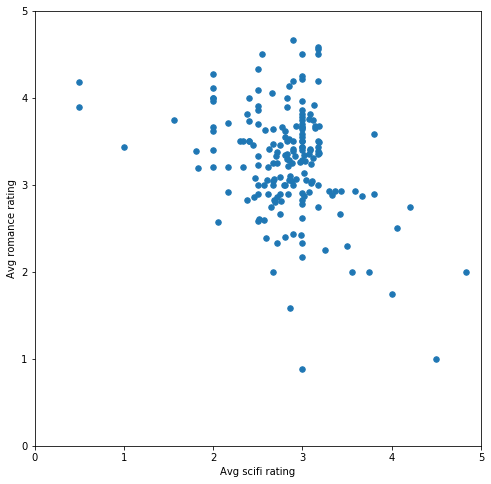

In [7]:
%matplotlib inline


helper.draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

We can see come clear bias in this sample (that we created on purpose). How would it look if we break the sample down into two groups using k-means?

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values
print(X)

[[ 2.4   3.5 ]
 [ 3.14  3.65]
 [ 2.75  2.9 ]
 [ 3.36  2.93]
 [ 2.62  2.89]
 [ 2.51  2.61]
 [ 3.12  3.31]
 [ 3.07  3.76]
 [ 3.17  3.  ]
 [ 3.    0.88]
 [ 2.83  3.3 ]
 [ 2.17  2.92]
 [ 3.    4.25]
 [ 2.7   3.33]
 [ 2.    3.96]
 [ 3.12  3.75]
 [ 2.65  2.75]
 [ 3.09  3.41]
 [ 3.43  2.93]
 [ 2.72  2.33]
 [ 2.5   4.33]
 [ 2.77  3.67]
 [ 2.89  3.  ]
 [ 2.93  3.68]
 [ 3.02  2.87]
 [ 2.38  3.81]
 [ 4.06  2.5 ]
 [ 3.17  3.35]
 [ 3.    2.17]
 [ 0.5   4.18]
 [ 3.14  3.68]
 [ 2.75  3.09]
 [ 3.    4.22]
 [ 2.    3.4 ]
 [ 3.18  3.39]
 [ 2.98  2.42]
 [ 2.67  3.  ]
 [ 2.57  2.6 ]
 [ 2.55  4.5 ]
 [ 3.59  2.93]
 [ 3.02  3.14]
 [ 3.17  4.56]
 [ 2.5   4.09]
 [ 3.    3.29]
 [ 2.83  3.89]
 [ 2.99  2.91]
 [ 2.5   3.  ]
 [ 3.    4.5 ]
 [ 3.    3.4 ]
 [ 3.17  3.44]
 [ 3.04  3.06]
 [ 2.5   3.86]
 [ 3.    3.78]
 [ 3.19  3.68]
 [ 2.67  3.25]
 [ 2.8   3.62]
 [ 2.84  2.9 ]
 [ 2.    3.2 ]
 [ 3.33  2.88]
 [ 2.97  3.26]
 [ 2.9   2.44]
 [ 2.85  3.53]
 [ 3.    2.83]
 [ 2.83  3.35]
 [ 3.07  2.92]
 [ 3.    2.78]
 [ 1.    3